In [1]:
using SparseArrays, PyPlot, LinearAlgebra, Polynomials

In [2]:
function euler_fluxes(r, ru, rv, rE)
    g = 7/5    
    p = @. (g - 1) * r * (rE / r - (ru^2 + rv^2)/(2*r^2))

    Frx = ru
    Fry = rv
    Frux = @. ru^2 / r + p
    Fruy = @. ru * rv / r 
    Frvx = @. ru * rv / r 
    Frvy = @. rv^2 / r + p
    FrEx = @. ru * (rE + p) / r
    FrEy = @. rv * (rE + p) / r

    return Frx, Fry, Frux, Fruy, Frvx, Frvy, FrEx, FrEy
end

euler_fluxes (generic function with 1 method)

In [3]:
function compact_div(Fx, Fy, h)
    m = size(Fx)[1]-1

    LHS = SymTridiagonal(4*ones(m+1), ones(m))
    LHS = sparse(LHS)
    LHS[1, end] = 1.0
    LHS[end, 1] = 1.0

    RHS = Tridiagonal(-3/h * ones(m), zeros(m+1), 3/h * ones(m))
    RHS = sparse(RHS)
    RHS[1, end] = -3/h
    RHS[end, 1] = 3/h
    
    Fx = reshape(Fx, (m+1,m+1))
    Fy = reshape(Fy, (m+1,m+1))
    divF = zeros(size(Fx))
    
    for col = 1:m+1
        divF[:,col] = divF[:,col] + LHS \ (RHS * Fx[:,col])
        divF[col,:] = divF[col,:] + LHS \ (RHS * Fy[col,:])
    end
    
    return divF
end


function test_compact_div()
    m = 99
    h = 1 /(m+1)

    x = (1:m+1) * h
    println(size(x))
    xx = reshape(repeat(x, m+1), (m+1, m+1))
    yy = Matrix(xx')

    divF1 = compact_div(0 * xx, sin.(2 * pi * yy), h)
    error1 = maximum(abs.(divF1 .- 2*pi .* cos.(2*pi*yy)))

    m = 49
    h = 1 /(m+1)

    x = (1:m+1) * h
    println(size(x))
    xx = reshape(repeat(x, m+1), (m+1, m+1))
    yy = Matrix(xx')

    divF2 = compact_div(0 .* xx, sin.(2 * pi * yy), h)
    error2 = maximum(abs.(divF2 .- 2*pi .* cos.(2*pi*yy)))

    display(error2/error1)

end

test_compact_div()

16.02257387918217

(100,)
(50,)


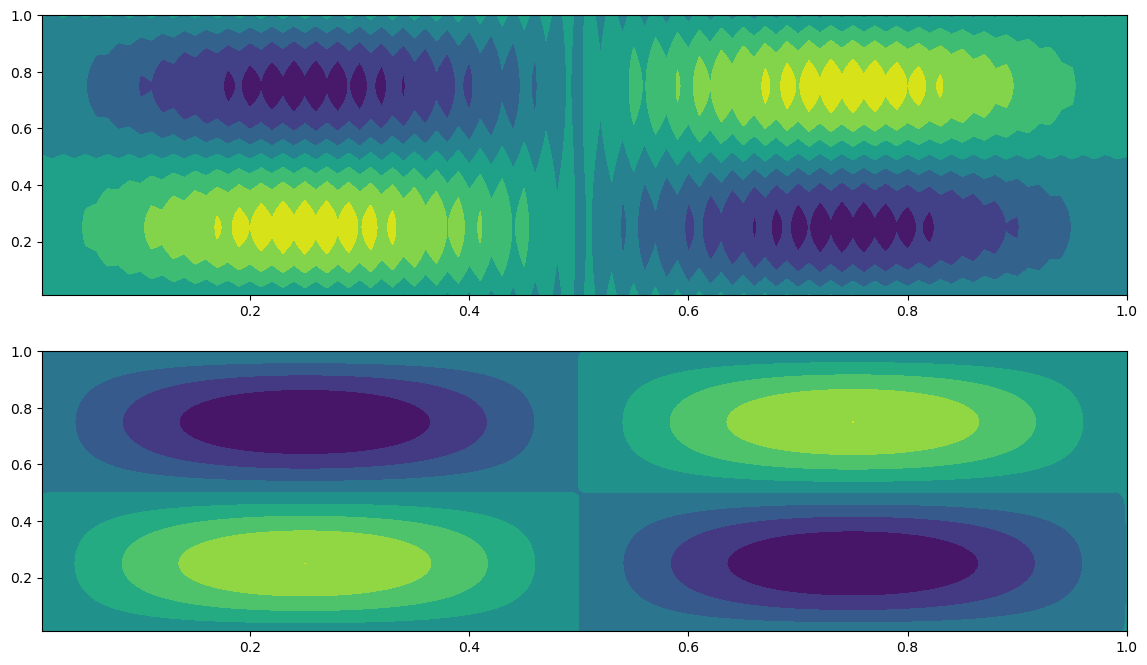

In [45]:
function compact_filter(u, alpha)
    a = 5/8 + 3*alpha/4
    b = alpha + 1/2
    c = alpha/4 - 1/8
    m = size(u)[1] - 1

    LHS = SymTridiagonal(ones(m+1), alpha * ones(m))
    LHS = sparse(LHS)
    LHS[1, end] = alpha
    LHS[end, 1] = alpha

    RHS = diagm(2 => c/2 * ones(m-1), 1 => b/2 * ones(m), 0 => a * ones(m+1), 
                -1 => b/2 * ones(m), -2 => c/2 * ones(m-1))

    RHS[1, end] = b/2
    RHS[1, end-1] = c/2
    RHS[2, end] = c/2
    RHS[end, 1] = b/2
    RHS[end, 2] = c/2
    RHS[end-1, 1] = c/2
    RHS = sparse(RHS)

    u = LHS \ (RHS * u)
    u = u'
    u = LHS \ (RHS * u)
    u = u'
    return u
end

function test_compact_filter()
    m = 99
    h = 1 /(m+1)
    alpha = 0.25

    x = (1:m+1) * h
    xx = reshape(repeat(x, m+1), (m+1, m+1))
    yy = Matrix(xx')


    clf()
    fig, ax = subplots(2, figsize = (14,8))

    u = sin.(2 * pi * xx) * sin.(2 * pi * yy) + 10*sin.(m * pi * xx)

    ax[1].contourf(xx, yy,  u)


    uhat = compact_filter(u, alpha)
    ax[2].contourf(xx, yy,  uhat)
 

    gcf()
end

test_compact_filter()

In [5]:
function euler_rhs(r, ru, rv, rE, h)
    Frx, Fry, Frux, Fruy, Frvx, Frvy, FrEx, FrEy =  euler_fluxes(r, ru, rv, rE)
    
    fr = compact_div(Frx, Fry, h)
    fru = compact_div(Frux, Fruy, h)
    frv = compact_div(Frvx, Frvy, h)
    frE = compact_div(FrEx, FrEy, h)
    
    return fr, fru, frv, frE 
end

euler_rhs (generic function with 1 method)

In [13]:
function euler_vortex(x, y, time, pars)
    γ  = 1.4
    rc = pars[1]
    ϵ  = pars[2]
    M₀ = pars[3]
    θ  = pars[4]
    x₀ = pars[5]
    y₀ = pars[6]

    r∞ = 1
    u∞ = 1
    E∞ = 1/(γ*M₀^2*(γ - 1)) + 1/2
    p∞ = (γ - 1) * (E∞ - 1/2)
    ubar = u∞ * cos(θ)
    vbar = u∞ * sin(θ)
    f = @. (1 - ((x - x₀) - ubar*time)^2 - ((y - y₀) - vbar*time)^2) / rc^2

    u = @. u∞ * (cos(θ) - ϵ*((y - y₀)-vbar*time) / (2π*rc) * exp(f/2))
    v = @. u∞ * (sin(θ) + ϵ*((x - x₀)-ubar*time) / (2π*rc) * exp(f/2))
    r = @. r∞ * (1 - ϵ^2 * (γ - 1) * M₀^2/(8π^2) * exp(f))^(1/(γ-1))
    p = @. p∞ * (1 - ϵ^2 * (γ - 1) * M₀^2/(8π^2) * exp(f))^(γ/(γ-1))
    
    ru = @. r*u
    rv = @. r*v
    rE = @. p/(γ - 1) + 1/2 * (ru^2 + rv^2) / r
    
    r, ru, rv, rE
end

euler_vortex (generic function with 1 method)

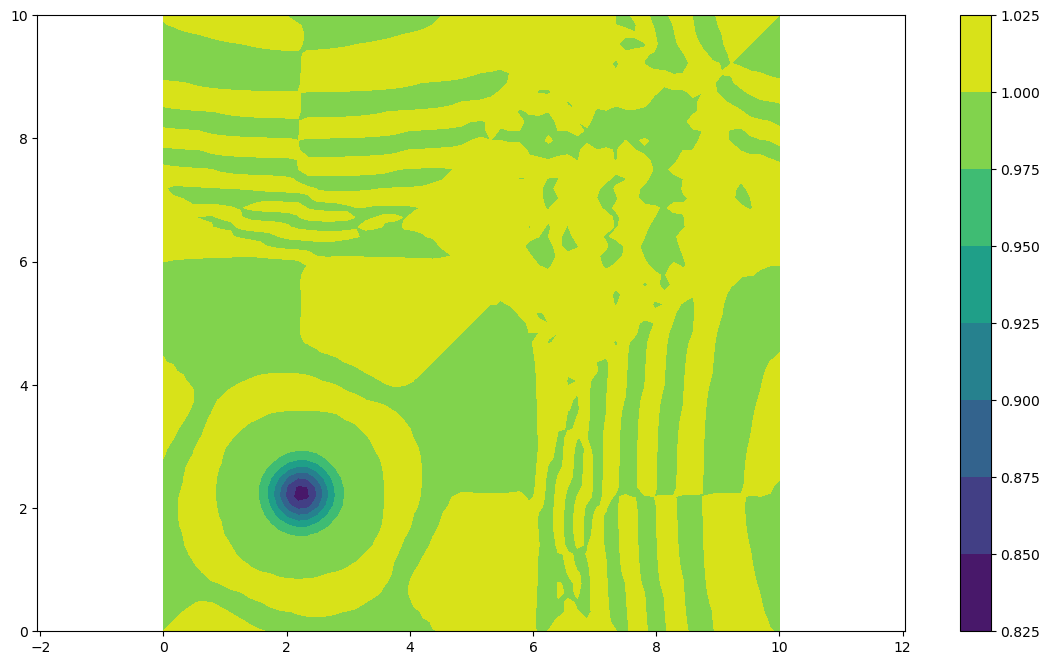

In [14]:
function euler_rk4step(r, ru, rv, rE, h, k, alpha)

    yn = [r, ru, rv, rE]
    k1 = euler_rhs(yn..., h)
    k2 = euler_rhs((yn .+ (k/2 .* k1))..., h)
    k3 = euler_rhs((yn .+ (k/2 .* k2))..., h)
    k4 = euler_rhs((yn .+ (k .* k3))..., h)

    ynp1 = @. yn + k*(k1 + 2*k2 + 2*k3 + k4)/6

    ynp1 = compact_filter.(ynp1, alpha)

    return ynp1
end

function test_euler_rk4step()
    N = 64
    h = 10 / N
    s = 0:h:10
    x = repeat(s, 1, length(s))
    y = Matrix(x')

    k = 0.3 * h

    M = ceil(Int64, 5sqrt(2)/k)
    k = 5sqrt(2) / M  


    pars = [0.5, 1, 0.5, pi/4, 2.5, 2.5]

    r0, ru0, rv0, rE0 = euler_vortex(x, y, 0, pars)

    r, ru, rv, rE = euler_rk4step(r0, ru0, rv0, rE0, h, k, 0.25)
    r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, 0.25)
    r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, 0.25)
    r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, 0.25)
    r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, 0.25)
    r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, 0.25)
    r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, 0.25)
    r, ru, rv, rE = euler_rk4step(r, ru, rv, rE, h, k, 0.25)
    clf()
    contourf(x, y, r)
    axis("equal")
    colorbar()
    gcf()
end

test_euler_rk4step()

In [46]:
function euler_rk4(x, y, u, N, T, alpha)
    h = 10 / N
    k = 0.3 * h
    M = ceil(Int64, T/k)
    k = T / M

    for i = (0:k:T)
        u = euler_rk4step(u..., h, k, alpha)
    end
    
    return u
end

function test_euler_rk4()
    N = 32
    h = 10 / N
    s = h:h:10
    x = repeat(s, 1, length(s))
    y = Matrix(x')
    T = 5sqrt(2)

    pars = [0.5, 1, 0.5, pi/4, 2.5, 2.5]

    u0 = euler_vortex(x, y, T, pars)
    u = euler_vortex(x, y, 0, pars)

    u = euler_rk4(x, y, u, N, T, 0.48)

    errors = zeros(4)
    for i = (1:4)
        errors[i] = maximum(abs.(u[i] .- u0[i]))
    end
    display(errors)
    clf()
    contourf(x, y, u[1])
    axis("equal")
    colorbar()
    gcf()
end

#test_euler_rk4()

test_euler_rk4 (generic function with 1 method)

In [20]:
function calculate_error(N, alpha, pars)
    h = 10 / N
    s = h:h:10
    x = repeat(s, 1, length(s))
    y = Matrix(x')
    T = 5sqrt(2)

    u_exact = euler_vortex(x, y, T, pars)
    u_init = euler_vortex(x, y, 0, pars)
    u = euler_rk4(x, y, u_init, N, T, alpha)
    
    error = 0
    for (component, component_exact) = zip(u, u_exact)
        error = maximum([error, maximum(abs.(component .- component_exact))])
    end
    return error
end

calculate_error (generic function with 1 method)

In [21]:
function validate_solver(alpha, Ns)
    pars = [0.5, 1, 0.5, pi/4, 2.5, 2.5]
    
    errors = zeros(length(Ns))
    fig, ax = subplots(figsize=(14,8))

    for i = (1:length(Ns))
        errors[i] = calculate_error(Ns[i], alpha, pars)
    end
    return errors
end


validate_solver (generic function with 1 method)

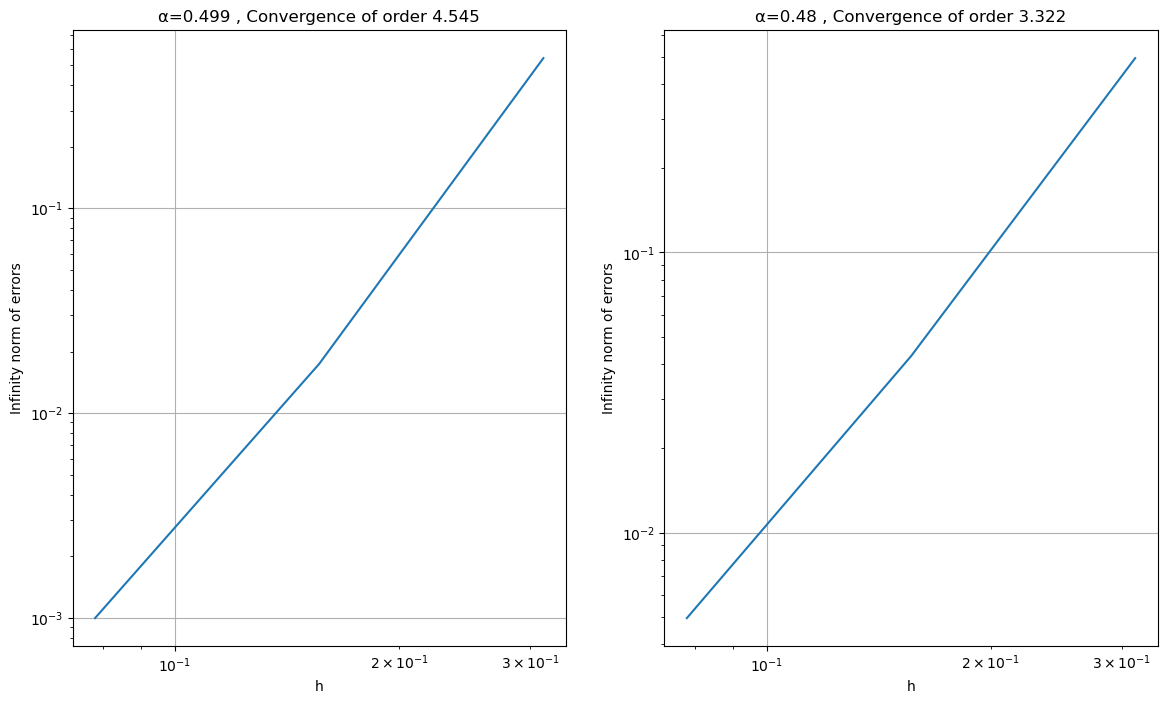

In [22]:
function convergence_plot()
    alphas = [0.499, 0.48]
    Ns = [32, 64, 128]
    hs = 10.0 ./ Ns
    fig, axs = subplots(1,2, figsize=(14,6))
    for i = (1:2)
        errors = validate_solver(alphas[i], Ns)
        fit = Polynomials.fit(log.(hs), log.(errors), 1)
        order = coeffs(fit)[2]
        axs[i].set_title("α=$(alphas[i]) , Convergence of order $(round(order,digits=3))")
        axs[i].loglog(hs, errors)
        axs[i].set_xlabel("h")
        axs[i].set_ylabel("Infinity norm of errors")
        axs[i].grid(true)
    end
    display(fig)
end
convergence_plot()

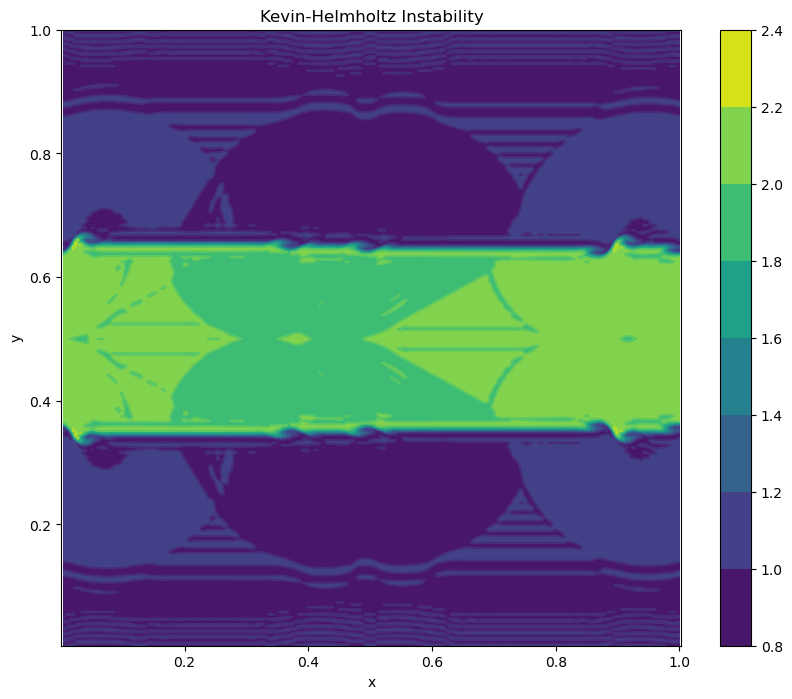

In [70]:
function Kevin_Helmholtz()
    N = 256
    h = 1/N
    s = h:h:1
    x = repeat(s, 1, length(s))
    y = Matrix(x')
    T = 1
    alpha = 0.48

    p = 3
    gamma = 7/5
    r0 = ones(size(x))
    r0 = @. ifelse(abs(y-0.5) < 0.15 + sin(2*pi * x) / 200, 2, 1)
    ru0 = r0 .* (r0 .- 1)
    rv0 = r0 .* 0
    rE0 = @. p / (gamma-1) + (ru0^2+rv0^2) / (2*r0)
    y0 = [r0, ru0, rv0, rE0]

    r, ru, rv, rE = euler_rk4(x, y, y0, N, T, alpha)

    fig, ax = subplots(figsize = (10,8))
    ax.contour(x, y, r)
    pcm = ax.contourf(x, y, r)
    ax.set_title("Kevin-Helmholtz Instability")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    axis("equal")
    fig.colorbar(pcm, ax=ax)
    display(fig)
end

Kevin_Helmholtz()